In [1]:
import os
os.listdir()

['.ipynb_checkpoints',
 'animation_correction.gif',
 'animation_moving.gif',
 'fmri.nii.gz',
 'fmri_dicom_folder',
 'Motion_correction_pure.ipynb']

In [2]:
import nibabel as nib
import numpy as np

import SimpleITK as sitk
import imageio
from IPython.display import Image

import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(precision=3, suppress=True)
plt.figure() #Это я делаю, чтобы избежать непонятного конфликта matplotlib и pytorch

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [3]:
fmri_data = nib.load('fmri.nii.gz')

In [4]:
%%capture 
#Вылетают требовния сконвертировать данные в uint8, отключаю их. Все и так работает. 

fmri_array = fmri_data.get_fdata()
images = []
for i in range(fmri_array.shape[-1]):
    images.append(fmri_array[:,:,20,i])
    
imageio.mimwrite('animation_moving.gif', images, duration=0.1)

<img src="animation_moving.gif" width="200" align="center">

In [5]:
fmri_data.affine

array([[ -1.734,  -0.039,  -0.065, 113.858],
       [ -0.047,   1.666,   0.829, -95.687],
       [ -0.025,  -0.48 ,   2.883,  -0.641],
       [  0.   ,   0.   ,   0.   ,   1.   ]])

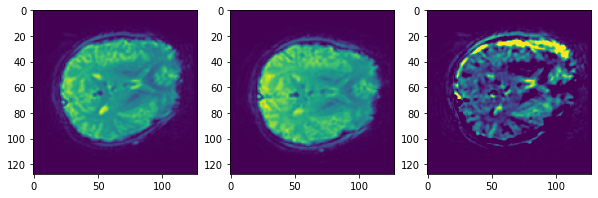

In [6]:
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(fmri_array[:,:,20,0])
plt.subplot(132)
plt.imshow(fmri_array[:,:,20,4])
plt.subplot(133)
plt.imshow(fmri_array[:,:,20,0] - fmri_array[:,:,20,4], vmin=0, vmax=5000)

In [7]:
import torch 
from torch import nn
import torch.nn.functional as F

device = torch.device("cuda:0")
torch.cuda.get_device_name(0)
torch.set_printoptions(sci_mode=False)

In [8]:
fixed = torch.from_numpy( fmri_array[:,:,:,0] ).to(device)
moving = torch.from_numpy( fmri_array[:,:,:,4] ).to(device)

fixed = fixed.unsqueeze(0).unsqueeze(0).cuda()
moving = moving.unsqueeze(0).unsqueeze(0).cuda()

In [9]:
class RotationTransformer(nn.Module):
    def __init__(self):
        super(RotationTransformer, self).__init__()
        
        self.angle_x = nn.Parameter(torch.tensor(0.))
        self.angle_y = nn.Parameter(torch.tensor(0.))
        self.angle_z = nn.Parameter(torch.tensor(0.))
        
        self.translation_x = nn.Parameter(torch.tensor(0.))
        self.translation_y = nn.Parameter(torch.tensor(0.)) 
        self.translation_z = nn.Parameter(torch.tensor(0.))
        
        
    def forward(self, moving):
        
        x_cos = torch.cos(self.angle_x)
        x_sin = torch.sin(self.angle_x)
        
        y_cos = torch.cos(self.angle_y)
        y_sin = torch.sin(self.angle_y)
        
        z_cos = torch.cos(self.angle_z)
        z_sin = torch.sin(self.angle_z)
        
        rotation_x = torch.eye(4, 4, dtype=torch.double, device='cuda').unsqueeze(0)
        rotation_y = torch.eye(4, 4, dtype=torch.double, device='cuda').unsqueeze(0)
        rotation_z = torch.eye(4, 4, dtype=torch.double, device='cuda').unsqueeze(0)
        
        rotation_x[0][1,1] = x_cos
        rotation_x[0][1,2] = -x_sin
        rotation_x[0][2,1] = x_sin
        rotation_x[0][2,2] = x_cos
        rotation_x[0][0,3] = self.translation_x 
        
        rotation_y[0][0,0] = y_cos
        rotation_y[0][0,2] = y_sin
        rotation_y[0][2,0] = -y_sin
        rotation_y[0][2,2] = y_cos
        rotation_y[0][1,3] = self.translation_y 
        
        rotation_z[0][0,0] = z_cos
        rotation_z[0][0,1] = -z_sin
        rotation_z[0][1,0] = z_sin
        rotation_z[0][1,1] = z_cos
        rotation_z[0][2,3] = self.translation_z
        
        affine = (rotation_z @ rotation_y @ rotation_x)[:,:3,:4]

        grid = F.affine_grid(affine, moving.size())
        resampled = F.grid_sample(moving, grid)
        return resampled

In [10]:
transformer = RotationTransformer()

In [11]:
optim = torch.optim.Adam(transformer.parameters(), lr=0.01)
mse = nn.MSELoss()

losses = []
images = []

for i in range(60):
    optim.zero_grad()
    resampled = transformer(moving)
    
    loss = mse(fixed, resampled)
    losses.append(loss.item())
    loss.backward()
    optim.step()
    
    im = np.array(resampled[0,0,:,:,20].detach().cpu().numpy(), dtype=np.float64)
    images.append(im)

D:\Anaconda3\envs\neuroenv\lib\site-packages\torch\nn\functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
D:\Anaconda3\envs\neuroenv\lib\site-packages\torch\nn\functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


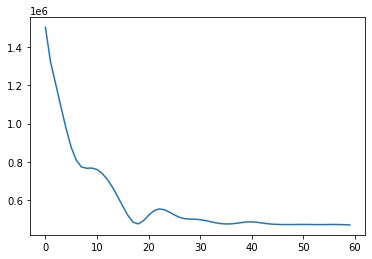

In [12]:
plt.plot(losses)

In [13]:
%%capture 
#Вылетают требовния сконвертировать данные в uint8, отключаю их. Все и так работает. 
import imageio
imageio.mimwrite('animation_correction.gif', images, duration=0.1)

<img src="animation_correction.gif" width="200" align="center">

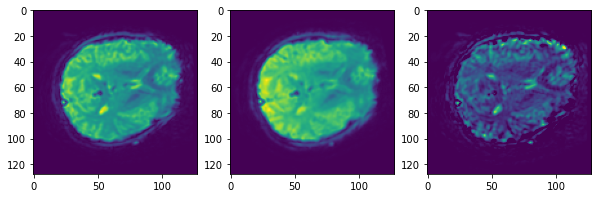

In [14]:
corrected = resampled[0,0,:,:,20].detach().cpu().numpy()

plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(fmri_array[:,:,20,0])
plt.subplot(132)
plt.imshow(corrected)
plt.subplot(133)
plt.imshow(fmri_array[:,:,20,0] - corrected, vmin=0, vmax=5000)